# Severstal: Steel Defect Detection

https://www.kaggle.com/c/severstal-steel-defect-detection

In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader, sampler
from torchvision import transforms as T
from torchvision import models

from PIL import Image

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime

from severstal_utils import *
from severstal_models import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TRAIN_PATH = 'train_images'
TEST_PATH = 'test_images'
MODEL_PATH = 'models/'
SUBMS_PATH = 'submissions/'


if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

In [4]:
img_mean = (0.3438812517320017,)
img_std = (0.13965334396720055,)

transform_train = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=img_mean, std=img_std)
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=img_mean, std=img_std)
])

In [5]:
# Splitting to training and validation parts
imglist = os.listdir(TRAIN_PATH)
imglist_train, imglist_val = train_test_split(imglist, test_size=0.2, random_state=0)

# Datasets
ds_train = SteelFramesDataset(TRAIN_PATH, imglist_train, masks_csv='train.csv', transform=transform_train)
ds_val = SteelFramesDataset(TRAIN_PATH, imglist_val, masks_csv='train.csv', transform=transform_val)

In [6]:
params_loader = {
    'batch_size': NUM_FRAMES,
    'num_workers': 5,
    'pin_memory': True
}

# Data loaders
loader_train = DataLoader(
    ds_train,
    shuffle=True,
    **params_loader
)
loader_val = DataLoader(
    ds_val,
    shuffle=False,
    **params_loader)

In [7]:
# Model defenition
params_unet = {
    'depth': 5,
    'n_filters': 48,
    'bn': True,
    'activation': 'relu'
}

unet = UnetD(**params_unet)
unet = unet.to(device=device);

detector = Detector(unet, device)

In [8]:
%%time

params_train = {
    'epochs': 20,
    'print_every': 0,
    'lr': 0.0001,
}

loss_fun = torch.nn.CrossEntropyLoss()

detector.fit(loader_train, loader_val, loss_fun, **params_train)

After 1 epochs:
Training loss = 0.15935544126262466
Validation loss: 0.08538261913558902

After 2 epochs:
Training loss = 0.08744369887884244
Validation loss: 0.07844084757964812

After 3 epochs:
Training loss = 0.0775679095511319
Validation loss: 0.07933084460166158

After 4 epochs:
Training loss = 0.07175778589444004
Validation loss: 0.06424047393557698

After 5 epochs:
Training loss = 0.06790531449944284
Validation loss: 0.06890474486241571

After 6 epochs:
Training loss = 0.0638902123871709
Validation loss: 0.0577461138220131

After 7 epochs:
Training loss = 0.06078259489409388
Validation loss: 0.060318675620431174

After 8 epochs:
Training loss = 0.05828855474435056
Validation loss: 0.05875995728729467

After 9 epochs:
Training loss = 0.05569580079260854
Validation loss: 0.05591984490065088

After 10 epochs:
Training loss = 0.05435475608244405
Validation loss: 0.057306175560716176

After 11 epochs:
Training loss = 0.05258074109871013
Validation loss: 0.05895162319018046

After 12 

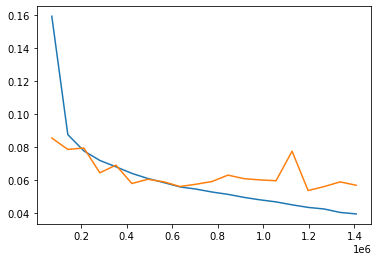

In [9]:
plt.plot(
    detector.n_frames, detector.loss_history,
    detector.n_frames, detector.val_loss_history,
);

In [10]:
# Save weights
# Final state
fname_wts_final = f"unetd_D{params_unet['depth']}F{params_unet['n_filters']}E{params_train['epochs']}_final.pth"
torch.save(detector.model.state_dict(), os.path.join(MODEL_PATH, fname_wts_final))

# # Best weights
# fname_wts_best = f'unetd_D{params_unet['depth']}F{params_unet['n_filters']}E{params_train['epochs']}_best.pth'
# torch.save(detector.best_model_wts, os.path.join(MODEL_PATH, fname_wts_best))

In [ ]:
# Load weights
detector.model.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'unetd_D5F16E1_final.pth')))